In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import data set

In [3]:
data_set = pd.read_csv("./data/train.csv")
data_set.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


check for null value and remove them or fill them


In [4]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


above is retrieving the data types

dropping unneccessary columns eg store  and items 

In [5]:
data_set = data_set.drop(['store', 'item'], axis=1)

In [6]:
# getting the new data set
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


convert date datatype from object to datetime datatype

In [7]:
data_set['date'] = pd.to_datetime(data_set['date'])

In [8]:
#check the datatype
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


converting date to a month period and sum the number of items in each month

In [9]:
data_set['date'] = data_set['date'].dt.to_period('M')
monthly_sales = data_set.groupby('date').sum().reset_index()

convert the resulting date column to timestamp datatpe

In [10]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [11]:
#get the sample
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


visualize the sales for monthly items

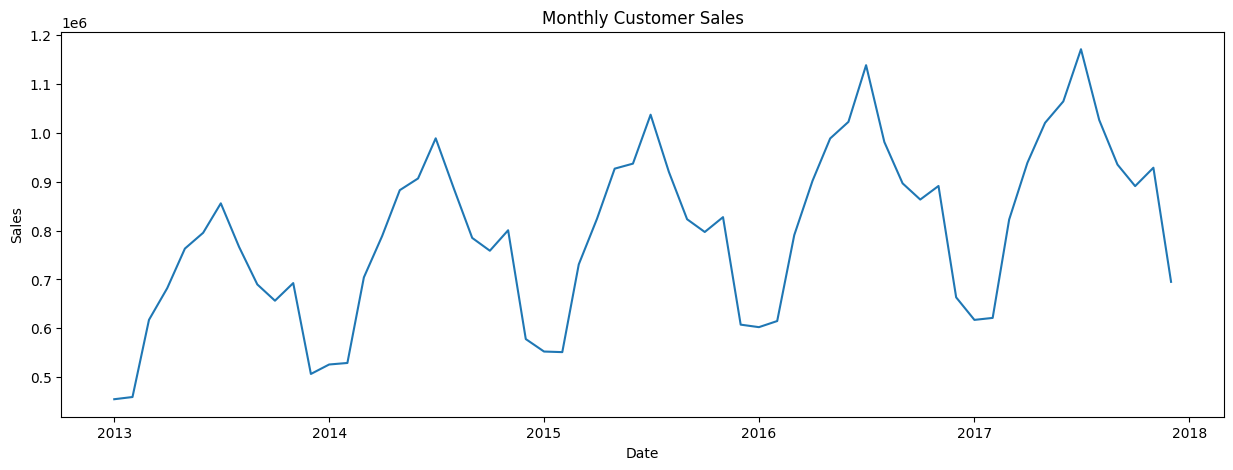

In [12]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

call the diff between sales column to make the sales data stationary


In [13]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


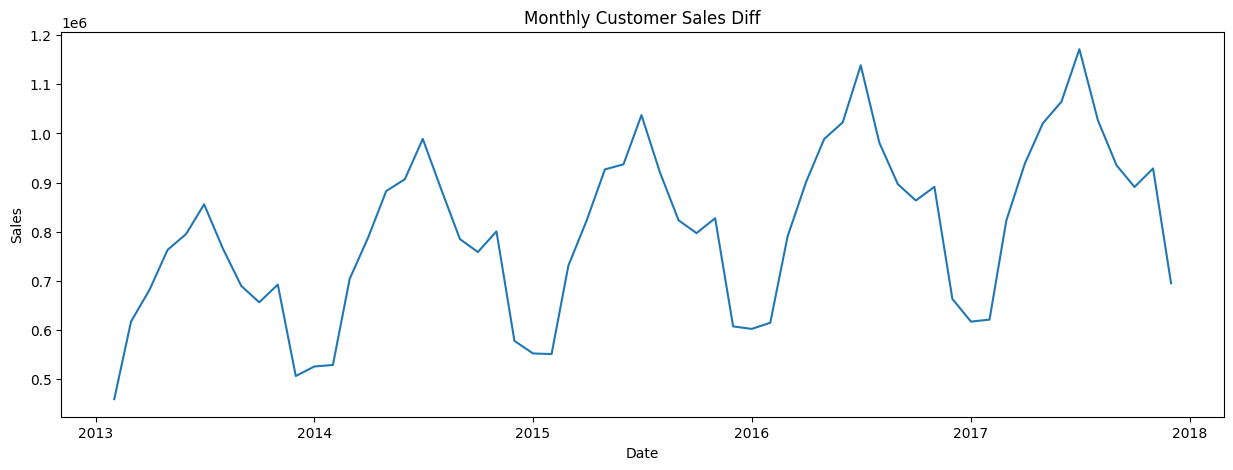

In [14]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales Diff")
plt.show()

Drop date and sales column and create supervised data

In [15]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)


prepare the supervised data

In [16]:
#using te prev 12 months sales as the input feature and te next month sale as the output
for i in range(1, 13):
    col_name = 'month' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


Split the data into train and test data

In [17]:
#this is for the prev 12 months
train_data = supervised_data[:-12]
#this is for the upcoming 12 months
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


Restrict the feature values in range of  from -1 & 1

In [19]:
scaler = MinMaxScaler(feature_range=(-1,1))
#fit the trainer data 
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)


In [20]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1] 
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x-train shape: ", x_train.shape)
print("y-train shape: ", y_train.shape)
print("x-test shape: ", x_test.shape)
print("y-test shape: ", y_test.shape)

x-train shape:  (35, 12)
y-train shape:  (35,)
x-test shape:  (12, 12)
y-test shape:  (12,)


1st Columns are Outputs any column after is the input

MAKE PREDICTION DATA FRAME TO MERGE THE PREDICTED SALES PRICES OF ALL TRAINED ALGS

In [21]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_data_frame = pd.DataFrame(sales_dates)

actual monthly  sales for the last 13 months

In [22]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


CREATE THE LINEAR REGRESSION MODEL AND PREDICT OUTPUT

In [23]:
linear_reg_model = LinearRegression()
linear_reg_model.fit(x_train, y_train)
lr_pre = linear_reg_model.predict(x_test)

In [25]:
lr_pre = lr_pre.reshape(-1,1)
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [26]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_data_frame = predict_data_frame.merge(lr_pre_series, left_index= True, right_index= True)


In [27]:
lr_mnsd_err = np.sqrt(mean_squared_error(predict_data_frame["Linear Prediction"], monthly_sales["sales"][-12:]))
lr_abso_err = mean_absolute_error(predict_data_frame["Linear Prediction"], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_data_frame['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linear Regression Mean Squared Error: ", lr_mnsd_err)
print("Linear Regression Mean Absolute Error: ", lr_abso_err)
print("Linear Regression R2 Score: ", lr_r2)


Linear Regression Mean Squared Error:  116719.57703032004
Linear Regression Mean Absolute Error:  95980.2547628299
Linear Regression R2 Score:  0.5377514080121066


Visualize Actial Sales Against Predictions

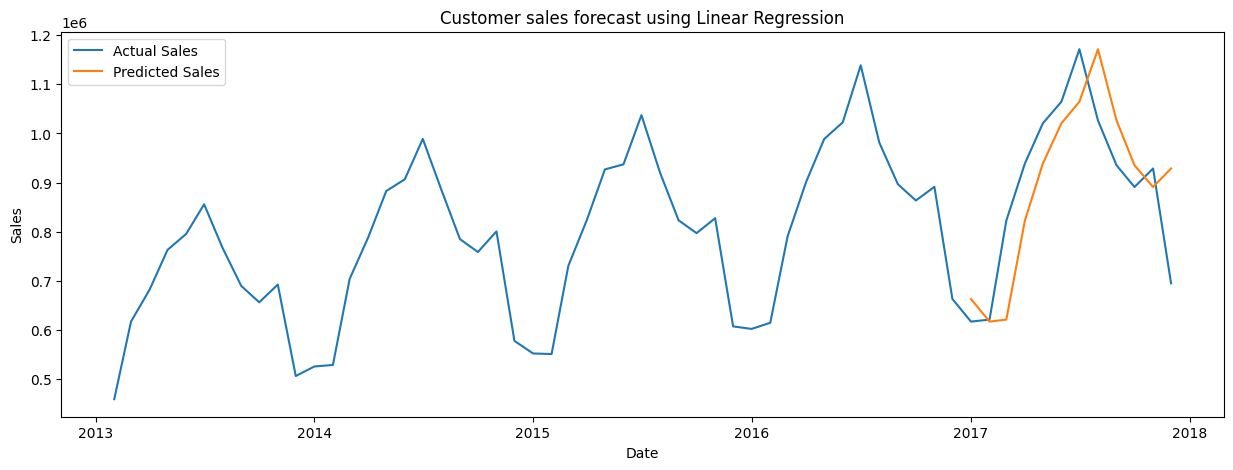

In [28]:
plt.figure(figsize=(15,5))
#Actual sale
plt.plot(monthly_sales['date'], monthly_sales['sales'])
#Predicted sales
plt.plot(predict_data_frame['date'], predict_data_frame['Linear Prediction'])
plt.title("Customer sales forecast using Linear Regression")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()